In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from src.cifar_autoencoder import CifarDataSet, AutoEncoder, train
from src.cifar_graph_classifier import Net
from torch.utils.data import DataLoader

In [3]:
train_ds = CifarDataSet(
            batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", mode="train"
        )
test_ds = CifarDataSet(
    batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", mode="test"
)
sample_ds = CifarDataSet(
    batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", mode="sample"
)

In [4]:
m = AutoEncoder()

In [5]:
tl = DataLoader(test_ds,batch_size=64)

In [6]:
ops = train(m, tl, 2)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:1, Loss:0.0317


100%|██████████| 157/157 [04:11<00:00,  1.60s/it]

Epoch:2, Loss:0.0177


In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
all_losses = []
index = 0
for i,x in ops[-1]:
    all_losses.append({"counter":index,"epoch":i+1,"iteration":index+1,"loss":x})
    index+=1

In [9]:
loss_df = pd.DataFrame(all_losses)

<AxesSubplot:xlabel='counter', ylabel='loss'>

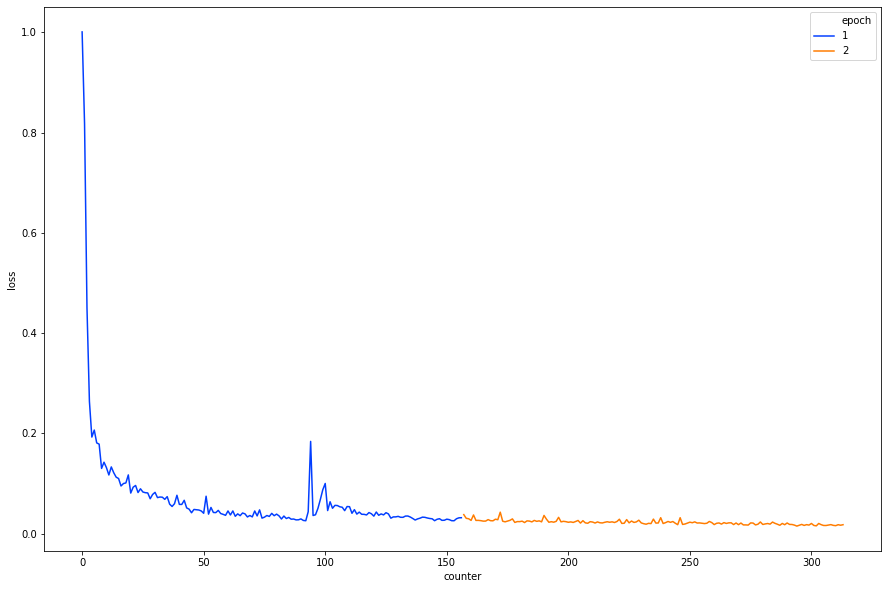

In [10]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

In [11]:
imgs = ops[0][-1][1].reshape(-1,3,32,32).numpy()

In [12]:
imgs = imgs.transpose(0,2,3,1)

In [13]:
pred = ops[0][-1][2].reshape(-1,3,32,32).detach().numpy()

In [14]:
pred = pred.transpose(0,2,3,1)

In [15]:
index = 10

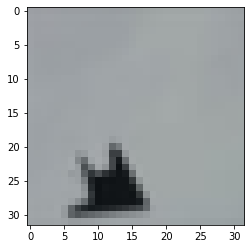

In [16]:
plt.imshow(imgs[index])

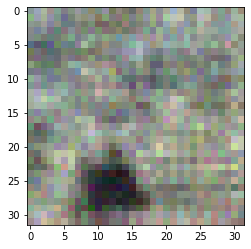

In [17]:
plt.imshow(pred[index])

In [18]:
n = Net(num_classes=10,
        encoder_model=m,
        sample_dataset=sample_ds,
        train_dataset=train_ds,
        num_epochs=3,
        learning_rate=1e-3,
        seed=42,
        use_graph=True)

2021-01-17 19:24:23.680 | INFO     | src.cifar_graph_classifier:__init__:51 - Computing the embedding for the train dataset
100%|██████████| 469/469 [02:35<00:00,  3.02it/s]
2021-01-17 19:27:04.559 | INFO     | src.cifar_graph_classifier:__init__:57 - Will use graph to augment features
2021-01-17 19:27:04.573 | INFO     | src.cifar_graph_classifier:__init__:58 - Computing the embedding for the sample dataset
100%|██████████| 157/157 [01:33<00:00,  1.68it/s]


In [49]:
n.sanity_test()

2021-01-17 21:04:21.305 | INFO     | src.cifar_graph_classifier:test_forward_run:195 - x.shape = torch.Size([1, 1024])
2021-01-17 21:04:21.308 | INFO     | src.cifar_graph_classifier:test_forward_run:196 - x[:,:10] = tensor([[ 0.2474,  1.6053, -1.4513,  0.9107, -2.6387, -2.9130,  0.5349,  1.1342,
         -1.5618, -0.9581]])
2021-01-17 21:04:21.310 | INFO     | src.cifar_graph_classifier:test_forward_run:197 - sample_xs.shape = torch.Size([2048, 1024])
2021-01-17 21:04:21.314 | INFO     | src.cifar_graph_classifier:test_forward_run:198 - sample_xs[:5,:10] = tensor([[ 1.2533,  0.8996, -1.0895,  0.3118, -2.4584, -2.8938, -0.0376,  0.3619,
         -1.4842, -0.9953],
        [ 0.8964,  2.1632, -1.0065,  0.8612, -3.2488, -3.6389,  0.2153,  0.1676,
         -1.1659, -1.3769],
        [-1.4272,  3.1325,  0.2161,  2.1071, -2.2627, -1.2914,  0.3769,  1.9542,
         -0.4834, -0.4056],
        [-3.6812, -2.9579,  1.2226, -0.5393,  5.5416,  6.9867,  0.9026, -1.3072,
          5.1048,  2.5887],


In [50]:
from torch_geometric.nn.conv import GCNConv

In [ ]:
GCNConv()

In [50]:
loss = n.train()

2021-01-16 22:38:39.452 | INFO     | src.cifar_graph_classifier:train:192 - Epoch 1 of 1
100%|██████████| 469/469 [03:41<00:00,  2.12it/s]


In [51]:
all_losses = []
index = 0
for i,x in enumerate(loss):
    for j,y in enumerate(x):
        all_losses.append({"counter":index,"epoch":i+1,"iteration":j+1,"loss":y})
        index+=1

In [52]:
loss_df = pd.DataFrame(all_losses)

# w/o graph

<AxesSubplot:xlabel='counter', ylabel='loss'>

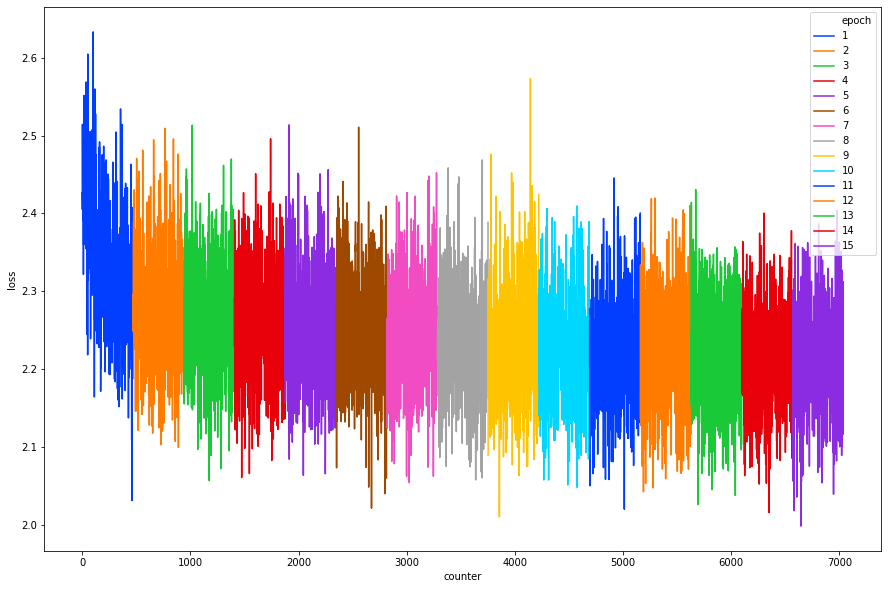

In [28]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

# w graph

<AxesSubplot:xlabel='counter', ylabel='loss'>

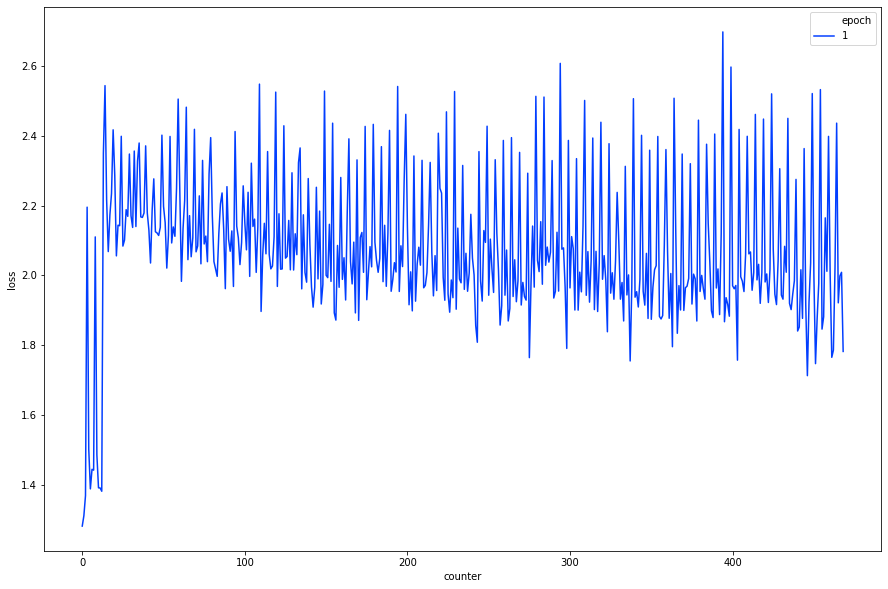

In [53]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

In [54]:
clf_test_loader = n.get_encoding(sample_ds, 64)

100%|██████████| 157/157 [01:09<00:00,  2.27it/s]


In [55]:
from tqdm import tqdm
import torch

In [56]:
res = []
for data in tqdm(clf_test_loader):
    img, label = data
    recon = n.forward(img)
    _, preds = torch.max(recon, 1)
    bool_tensor = preds == label
    res.append(torch.stack([label,bool_tensor,preds],dim=1))

100%|██████████| 157/157 [00:34<00:00,  4.51it/s]


In [57]:
all_res = torch.cat(res,dim=0)

In [58]:
import numpy as np

In [59]:
df_test_res = pd.DataFrame(all_res.numpy(),columns=["class","res","pred_class"])

# w/o graph

In [60]:
df_test_res.groupby("res").count()/df_test_res.shape[0]

,class,pred_class
res,,
0,0.8659,0.8659
1,0.1341,0.1341


In [61]:
confusion_matrix = pd.crosstab(df_test_res['class'], df_test_res['pred_class'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,198,124,47,83,63,94,42,75,158,119
1,135,115,49,91,71,100,63,106,121,112
2,97,97,86,113,131,96,127,135,75,84
3,114,111,84,108,112,72,84,125,77,89
4,60,78,94,105,160,86,138,146,62,75
5,116,105,70,106,106,101,100,124,106,87
6,62,81,86,110,170,100,148,152,49,46
7,88,71,91,100,124,88,117,157,67,78
8,184,118,60,79,48,106,28,90,180,131
